In [1]:
import numpy as np
from numpy import genfromtxt
from trueskill import TrueSkill, Rating, quality_1vs1, rate_1vs1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy import stats
import operator as op
import pandas as pd
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
import math
import sys

# Griewank  function
## Optimization Methods
----
https://www.sfu.ca/~ssurjano/griewank.html

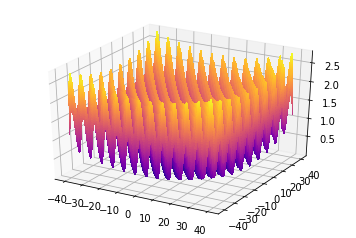

In [2]:
def griewank(*X, **kwargs):
    A = kwargs.get('A', 10)
    summ = 1 + sum([(x**2) for x in X])/4000
    I = 1
    mlty = 1
    for x in X:
        mlty = mlty * np.cos(x/math.sqrt(I))
        I = I + 1
    return summ - mlty
        

if __name__ == '__main__':
    X = np.linspace(-40, 40, 1100)    
    Y = np.linspace(-40, 40, 1100)    
    
    X, Y = np.meshgrid(X, Y)

    Z = griewank(X, Y, A=10)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
    plt.savefig('griewank', format='pdf')

## Simulated Annealing
---
### Cooling Schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

In [5]:
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

### Running the Algorithm

We define the `sa` function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [7]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    # out plot
    OUT_List_Simanneal = []
    Iterations = []
    
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    
    best_index=total
    best_temp=T
    for index in range(epochs):
        # print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            sys.stdout.write("\r Temperature " + str(T))
            sys.stdout.flush()
        # print("Temperature", T, "Length", length)
        for it in range(length):
            Iterations.append(total)
            total+=1
            new_solution = np.copy(old_solution)
            for y in new_solution:
                if proposalfunc == 'rdmGauss':
                    y[0] = y[0] + rdmGauss(sigma = 0.7)
                else:
                    y[0] = y[0] + rdmSimetricPoerLow(x1 = 3, x0 = 0.1, alpha = -1.5)
                if y[0] < -600:
                    y[0] = -600
                elif y[0] > 600:
                    y[0] = 600
                    
            # new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                OUT_List_Simanneal.append(new_energy)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
                OUT_List_Simanneal.append(old_energy)
    
    best_meta=dict(index=best_index, temp=best_temp)
    # print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator, OUT_List_Simanneal, Iterations

In [8]:
# http://mathworld.wolfram.com/RandomNumber.html
# https://stackoverflow.com/questions/918736/random-number-generator-that-produces-a-power-law-distribution
def rdmSimetricPoerLow(x1 = 3, x0 = 0.1, alpha = -1.5):
    y = np.random.uniform(0,1,1)
    x = math.pow((math.pow(x1, (alpha + 1)) - math.pow(x0, (alpha + 1)))*y + math.pow(x0, (alpha + 1)),(1/(alpha+1)))
    sign = np.random.uniform(0,1,1)
    return x if sign > 0.5 else -x

In [9]:
def rdmGauss(sigma = 0.2, mu = 0):
    return np.random.normal(mu, sigma, 1)

In [10]:
def Griewank(fevalMtx):
    summ = 1 + sum([(x[0]**2) for x in fevalMtx])/4000
    I = 1
    mlty = 1
    for x in fevalMtx:
        mlty = mlty * np.cos(x[0]/math.sqrt(I))
        I = I + 1
    return summ - mlty



In [11]:
def GriewankGradient(fevalMtx):
    delta = np.zeros((fevalMtx.shape[0], 1))
    mlty = 1
    I = 1
    for x in fevalMtx:
        mlty = mlty * np.cos(x[0]/math.sqrt(I))
        I = I + 1
    I = 1    
    for i in range(fevalMtx.shape[0]):
        delta[i][0] = (fevalMtx[i][0] * 2)/4000
        kmul = np.cos(fevalMtx[i][0]/math.sqrt(I))
        kmul = mlty/kmul
        inDelta = np.sin(fevalMtx[i][0]/math.sqrt(I))/math.sqrt(I)
        delta[i][0] = delta[i][0] + kmul*inDelta
        I = I + 1
   
    return delta

In [12]:
def min_GriewankPowerLaw(fevalMtx):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmSimetricPoerLow()
        
        if y[0] < -600 :
            y[0] = -600
        elif y[0] > 600:
            y[0] = 600

    prev = Griewank(fevalMtx);
    new = Griewank(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx
            

In [22]:
def min_GriewankHill(fevalMtx):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmGauss(sigma = 0.7)
        
        if y[0] < -600 :
            y[0] = -600
        elif y[0] > 600:
            y[0] = 600
    
    prev = Griewank(fevalMtx);
    new = Griewank(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx

In [23]:
def min_GriewankGradiente(fevalMtx, delta):
    alpha = 0.2;
    miu = 0.2;
    grad = GriewankGradient(fevalMtx)
    Y = np.copy(fevalMtx)
    for i in range(fevalMtx.shape[0]):
        delta[i][0] =  miu * delta[i][0] - grad[i][0] * alpha
        Y[i][0] = Y[i][0] + delta[i][0]
        
        if Y[i][0] < -600 :
            Y[i][0] = -600
        elif Y[i][0] > 600:
            Y[i][0] = 600
        
    
    new = Griewank(Y);
    
    return new, Y, delta 

In [32]:
Best_List_PowerLaw = []
Best_List_HillRice = []
Best_List_Gradient = []
Best_List_GaussSimanneal = []
Best_List_PwrSimanneal = []

valVectorSize = 10
if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
avgIterations = 100

OUT_List_PowerLaw = []
OUT_List_HillRice = []
OUT_List_Gradient = []
OUT_List_PwrSimanneal = []
OUT_List_GaussSimanneal = []
    
for j in range(0, avgIterations):
    print("Iteration......................................: %i" % j)
    print("````````````````````````````````````````````````")
       
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    
    print("Initial X Set: %s" % ([",".join(item) for item in fevalRdm.astype(str)]) )

    powerLawMtx = np.copy(fevalRdm)
    hillMtx = np.copy(fevalRdm)
    gradientMtx = np.copy(fevalRdm)
    simannealMtx = np.copy(fevalRdm)
    
    
    for i in range(iterSize):
        PowerLaw_OUT, powerLawMtx = min_GriewankPowerLaw(powerLawMtx)
        if len(OUT_List_PowerLaw) == iterSize :
            OUT_List_PowerLaw[i] = OUT_List_PowerLaw[i] + PowerLaw_OUT
        else:
            OUT_List_PowerLaw.append(PowerLaw_OUT)
        Iterations.append(i)
    #-----

    for i in range(iterSize):
        HillRice_OUT, hillMtx = min_GriewankHill(hillMtx)
        if len(OUT_List_HillRice) == iterSize :
            OUT_List_HillRice[i] = OUT_List_HillRice[i] + HillRice_OUT
        else:
            OUT_List_HillRice.append(HillRice_OUT)
    #-----
    
    for i in range(iterSize):
        Gradient_OUT, gradientMtx, delta = min_GriewankGradiente(gradientMtx,delta)
        if len(OUT_List_Gradient) == iterSize :
            OUT_List_Gradient[i] = OUT_List_Gradient[i] + Gradient_OUT
        else:
            OUT_List_Gradient.append(Gradient_OUT)
    #-----
    print("Final PowerLaw_OUT %f Solution: %s" % (PowerLaw_OUT, [",".join(item) for item in powerLawMtx.astype(str)]))
    Best_List_PowerLaw.append(PowerLaw_OUT)
    
    print("Final HillRice_OUT %f Solution: %s" % (HillRice_OUT, [",".join(item) for item in hillMtx.astype(str)]))
    Best_List_HillRice.append(HillRice_OUT)
    
    print("Final Gradient_OUT %f Solution: %s" % (Gradient_OUT, [",".join(item) for item in gradientMtx.astype(str)]))
    Best_List_Gradient.append(Gradient_OUT)
    #-----
    inits=dict(solution=simannealMtx, length=70, T=0.25)
    
    bmeta, bs, be, out, OUT_List_PwrSimanneal_Tmp, Iterations_PwrSimanneal = sa(Griewank,
                                                                            inits,
                                                                            SimannealItrSize,
                                                                            tf,
                                                                            itf,
                                                                            'rdmSimetricPoerLow')
    
    if len(OUT_List_PwrSimanneal) == 0:
        OUT_List_PwrSimanneal = [ b for b in OUT_List_PwrSimanneal_Tmp]
    else:
        OUT_List_PwrSimanneal[:] = [ (OUT_List_PwrSimanneal_Tmp[i] + OUT_List_PwrSimanneal[i]) for i in range(len(OUT_List_PwrSimanneal))]
        
    print("\n Final PwrSimanneal_OUT %f Solution: %s" % (be, [",".join(item) for item in bs.astype(str)]))
    Best_List_PwrSimanneal.append(be)
    #-----
    inits=dict(solution=simannealMtx, length=70, T=0.25)
    
    bmeta, bs, be, out, OUT_List_GaussSimanneal_Tmp, Iterations_GaussSimanneal = sa(Griewank,
                                                                                inits,
                                                                                SimannealItrSize,
                                                                                tf,
                                                                                itf,
                                                                                'rdmGauss')
    
    if len(OUT_List_GaussSimanneal) == 0:
        OUT_List_GaussSimanneal = [ b for b in OUT_List_GaussSimanneal_Tmp]
    else:
        OUT_List_GaussSimanneal[:] = [ (OUT_List_GaussSimanneal_Tmp[i] + OUT_List_GaussSimanneal[i]) for i in range(len(OUT_List_GaussSimanneal))]
        
    print("\n Final GaussSimanneal_OUT %f Solution: %s" % (be, [",".join(item) for item in bs.astype(str)]))
    Best_List_GaussSimanneal.append(be)


    
OUT_List_PowerLaw[:] = [x / avgIterations for x in OUT_List_PowerLaw]

OUT_List_HillRice[:] = [x / avgIterations for x in OUT_List_HillRice]

OUT_List_Gradient[:] = [x / avgIterations for x in OUT_List_Gradient]

OUT_List_PwrSimanneal[:] = [x / avgIterations for x in OUT_List_PwrSimanneal]

OUT_List_GaussSimanneal[:] = [x / avgIterations for x in OUT_List_GaussSimanneal]




Iteration......................................: 0
````````````````````````````````````````````````
Initial X Set: ['-68.41705116409562', '-52.87005507422342', '-14.17746174642123', '69.06546894755883', '79.89616337775195', '-51.20240426801559', '92.591682495788', '21.234815389840776', '29.70323606938402', '-63.24299722246136']
Final PowerLaw_OUT 4.433781 Solution: ['-40.87822072389259', '-35.582474442795444', '5.380535734540364', '50.047959089447936', '49.13265539294394', '-46.33390441050728', '65.98906774670662', '17.60145574126396', '19.22012224564981', '-48.82709916490521']
Final HillRice_OUT 3.909575 Solution: ['-50.154050513339044', '-30.9052171908991', '-10.731665415456098', '44.077357241720186', '49.001947744388026', '-22.8694042807748', '66.13081937187135', '-0.016044047225799996', '9.403812484501072', '-50.21537359564243']
Final Gradient_OUT 7.241965 Solution: ['-62.79982738866453', '-48.821920978698806', '-10.866166932125642', '62.70407604656191', '70.06979980237634', '-46.0

 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 0.878366 Solution: ['31.454978942876252', '-4.575505681822539', '11.249101893537278', '-6.523797835804489', '21.34631416802725', '-7.727422055901524', '8.502364753882691', '17.99430017568233', '-28.393226825776168', '-19.35184147239318']
Iteration......................................: 5
````````````````````````````````````````````````
Initial X Set: ['-8.080681978532425', '47.74351452498436', '31.924956360022293', '-11.71135721128671', '45.75391108769469', '97.19495605106806', '-6.507730133959583', '-13.422911204926805', '-79.03168197739008', '-48.82204875635119']
Final PowerLaw_OUT 4.656519 Solution: ['-3.233368267761113', '53.45509775511525', '27.183906586355647', '-6.232732806639874', '41.95564038550744', '84.60044417480398', '-0.04365014699910161', '-8.99237215295389', '-65.95935949691254', '-39.410882445290355']
Final HillRice_OUT 5.025508 Solution: ['-0.12493417195165157', '44.410068375714054', '27.42911660551539', '-12

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 2.072392 Solution: ['15.772414378482138', '48.811092933660795', '-21.775809811447314', '-12.47487892530578', '-13.792065322569137', '-46.033778080635955', '16.900093017113456', '-8.98343250620906', '-47.31165520623106', '0.41558760075142454']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.248802 Solution: ['-6.218480802251495', '26.647563618776307', '-32.60898901162155', '5.936131939259275', '-20.72464833295579', '-30.795127893843475', '8.4064834328913', '-27.25434951724654', '-18.63343508173663', '-19.704208270482855']
Iteration......................................: 10
````````````````````````````````````````````````
Initial X Set: ['-23.766880072958912', '-80.26790331781837', '-47.46320821955463', '-54.94091859232866', '-85.35759828921985', '24.915997213603333', '-79.83380356100639', '-49.13558323259826', '-86.99678551555463', '38.57807512920161']
Final PowerLaw_OUT 8.754331 Solution: ['-21.87437680647143', '-7

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.781991 Solution: ['-18.758449259052526', '17.614670964374035', '-38.08580499421413', '-12.223944307843569', '-0.2908719681501327', '0.02449144799073283', '-16.294769327796015', '-8.856930373028774', '18.80686528285518', '0.1695124658457139']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 0.314791 Solution: ['-15.833770299390586', '13.193750348785068', '-0.035064251616281086', '-6.127729640726264', '21.30800891711136', '0.04598553293372182', '8.281043677952601', '0.6003764585024202', '-0.0790361700967741', '-9.97604215803414']
Iteration......................................: 15
````````````````````````````````````````````````
Initial X Set: ['31.906724447319306', '-36.36733411912194', '-97.84267363020085', '76.86312522350337', '14.177266485431872', '-41.38019615619184', '46.68781275816255', '62.42622095751017', '-75.65479666271102', '58.08907189188807']
Final PowerLaw_OUT 8.711056 Solution: ['31.437031093838474', '

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.669198 Solution: ['18.905620275035695', '13.2497558271966', '-0.076940910174799', '-25.14974865560141', '14.3185686595674', '-0.04109430380445403', '16.251912057720762', '-26.714099064163683', '-9.885182967115341', '9.814983022752216']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 2.147933 Solution: ['31.287558519684865', '26.634972659538324', '-0.11506915936549411', '-37.96759499002966', '42.06646084402984', '23.108113627237692', '41.11051596554509', '-18.066265133181584', '-27.60355761767659', '10.269124390039432']
Iteration......................................: 20
````````````````````````````````````````````````
Initial X Set: ['8.988136519770507', '-48.48380093453704', '2.374236079824726', '-6.124160291768206', '0.9375340514004193', '-57.24404276864854', '-24.688900595647056', '-53.896628349301245', '68.3003875455114', '-57.73078307625341']
Final PowerLaw_OUT 2.035278 Solution: ['12.501808748375103', '-31.13

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.471971 Solution: ['-18.766855167025557', '-4.504412831948827', '10.698175097125967', '-12.383187015260946', '0.23381951394867914', '-0.11126919274877872', '-0.3194947753069299', '-17.550370309385936', '-28.043656356704336', '0.3118069295762174']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.735636 Solution: ['-34.48558889023807', '-22.388473276404046', '5.385237436203294', '-44.193122632420966', '6.875080169550839', '-0.33062300411779827', '-24.640807690845904', '-26.092091153346516', '-8.830771704432072', '-39.62303437842702']
Iteration......................................: 25
````````````````````````````````````````````````
Initial X Set: ['-84.9692129807299', '0.5189460049078036', '-97.83858581511787', '36.06287284715276', '62.00966795551389', '78.38809224427646', '71.19033042630144', '7.116071951616078', '-19.35493972853544', '88.36121838077818']
Final PowerLaw_OUT 6.499040 Solution: ['-72.25845198979829',

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.629210 Solution: ['-9.520257178411285', '4.516577037454204', '5.536879816766991', '-18.59231743276147', '-6.90996514067219', '-7.441731911354698', '-41.32352561708506', '-8.560985142759696', '-0.09679083957469087', '0.2637253236761346']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.563908 Solution: ['-12.550286066191935', '13.421974980392603', '38.18028840788862', '-12.348700114790502', '-21.036929693341804', '-7.6218305381767655', '-57.63529721827012', '-8.229740278909336', '9.350901087305433', '-9.782743193827127']
Iteration......................................: 30
````````````````````````````````````````````````
Initial X Set: ['-92.6492282433321', '-14.343605282781496', '4.239658878220325', '-73.62854286367013', '29.41185773424965', '-30.657500443340908', '36.874638953166226', '-93.8279500233925', '47.24441797013529', '39.21892119914867']
Final PowerLaw_OUT 5.679006 Solution: ['-78.52464129146105', '-17.51

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 1.758695 Solution: ['-15.704996845124263', '-44.37286781857849', '43.698667774917176', '12.788199766496994', '-13.783253970162802', '-7.50385013056275', '-16.715853458662778', '17.557489274759156', '-37.67411944178564', '19.777821529192618']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.654524 Solution: ['-21.92218311285682', '-39.89052148427162', '32.19921631837613', '37.50276223504315', '0.01688687454341145', '15.39243738089065', '-8.230045986981988', '26.658601631993353', '-28.458731103752054', '9.853269323968842']
Iteration......................................: 35
````````````````````````````````````````````````
Initial X Set: ['-15.471281100490188', '7.770079714125558', '-4.854923812586549', '-40.40389687409232', '33.71393553114311', '26.03221045237001', '-68.70311558210017', '28.761403863303826', '-88.29590285438209', '85.19535352429003']
Final PowerLaw_OUT 5.478681 Solution: ['-12.590598548578319', '17.95

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 2.650183 Solution: ['6.358060094259926', '-26.780031187227845', '-26.929463290820017', '-0.12194236066129857', '-70.20297735359763', '-53.41768776012928', '16.60029076588017', '-9.142221437392072', '-27.90603234119923', '-0.11203256729283653']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 5.009380 Solution: ['25.03678047754221', '-26.7490020238174', '-59.82050435429966', '0.06484924734466829', '-76.8567532042787', '-60.945907105533706', '57.76995988468609', '-17.40647337350647', '-37.22745708212794', '9.496416314213239']
Iteration......................................: 40
````````````````````````````````````````````````
Initial X Set: ['15.107534830252561', '81.7502185465537', '39.42245902646252', '30.449496801331293', '-51.29710726899474', '37.09673006472812', '18.517112526358147', '-4.521138151141329', '39.86117578033358', '-14.319085641209895']
Final PowerLaw_OUT 1.345427 Solution: ['9.466689411437715', '48.8900

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.800369 Solution: ['-3.2001488275773795', '4.408260444663798', '37.93568315361712', '12.243434537305816', '14.465956090561768', '-30.39201051588995', '-8.39336139236366', '8.913039188400761', '-0.17165718929502255', '9.791872720126648']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.903553 Solution: ['-3.146481601822681', '-21.96003741830171', '48.79941226345854', '19.168850094553168', '34.97236029230999', '-22.928385496680846', '16.45366471062099', '35.64005647736455', '28.027824105116732', '10.248820445581531']
Iteration......................................: 45
````````````````````````````````````````````````
Initial X Set: ['20.641282637504688', '78.67106955666293', '-16.42921953582963', '-28.59550961859098', '35.158750397746104', '-41.41320206261314', '11.594739947880072', '37.51965338806181', '46.19780950322331', '79.85711347965099']
Final PowerLaw_OUT 3.069719 Solution: ['12.640798990889294', '57.622702787

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 1.622771 Solution: ['-28.363724912380047', '-31.022875111545392', '-11.14241962029128', '-37.7791762100992', '27.864255051293163', '-23.097044672423756', '16.232343537900544', '-26.70483753014071', '18.68528260481836', '-19.908345634463913']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.609768 Solution: ['-40.664933778240105', '-35.540077757973386', '5.253610534713853', '-0.14908402412045177', '14.446753256397816', '-7.593638358752864', '24.85630799063654', '-44.17561344017999', '9.355134194999962', '-19.7268600595893']
Iteration......................................: 50
````````````````````````````````````````````````
Initial X Set: ['-85.66925627697518', '65.55959558187934', '-68.3813271816687', '-27.419928363225665', '-36.21534840461938', '-82.61294414648957', '91.63241415831999', '-88.01963350630417', '-97.24966756916749', '80.60980341183915']
Final PowerLaw_OUT 11.333301 Solution: ['-66.04504559729328', '62.

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.239058 Solution: ['0.0745583737679453', '-4.302003873198111', '10.996779590579834', '-6.218310384982917', '21.178231507411052', '7.534075687392161', '-8.503765633523344', '0.15323992374540485', '0.35976728747577336', '10.016144179920534']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.710970 Solution: ['12.666104699654507', '40.0248530243581', '21.979670963413955', '6.505956067131119', '41.814286351432585', '38.530876885956715', '-16.517433320363036', '-0.3582178688977629', '0.051790636377732124', '29.41499533480333']
Iteration......................................: 55
````````````````````````````````````````````````
Initial X Set: ['62.90025868718135', '79.97569214149942', '-19.10582852649172', '88.47796898028372', '82.30775640755604', '-87.42914561052223', '70.11788302350752', '78.11010866101122', '19.891852853254306', '-44.325004345698574']
Final PowerLaw_OUT 9.052469 Solution: ['62.70965407651085', '71.17339

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 2.005798 Solution: ['9.49236697734062', '-31.04105972490189', '16.23044526032919', '6.117319054929597', '-27.876390184785105', '22.767012741293698', '-24.587173132091216', '-26.31146575932522', '-37.00245875007478', '49.49681945874416']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.858804 Solution: ['-0.038040588079855275', '-26.485891197356494', '0.05822011880122524', '18.209092674096368', '-14.043860995155093', '53.524731746986554', '-32.91636317683756', '-26.38777959785776', '-18.6703796861935', '29.767742780203864']
Iteration......................................: 60
````````````````````````````````````````````````
Initial X Set: ['66.39705657675188', '91.6748260538501', '-8.958548650355795', '21.168558135889228', '67.09864473214333', '62.22826982310835', '-70.53781545223963', '10.482096344080148', '-64.46962921488064', '-32.05274718857514']
Final PowerLaw_OUT 5.766561 Solution: ['56.540590748298065', '79.692

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.923192 Solution: ['-28.26592813944701', '-17.799753698358632', '-5.438138085205135', '-18.756583032229372', '13.964544912922808', '23.21556547404526', '-7.752804289777145', '0.3996001096031519', '-19.041908063576464', '29.4747237077439']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 4.492520 Solution: ['-43.93982331282333', '-39.81391229977882', '0.3681669860104402', '-25.30539907657099', '55.90696922574818', '-38.044112624904876', '16.51742831121843', '-26.312400270699023', '-56.59982276656339', '69.09846722328574']
Iteration......................................: 65
````````````````````````````````````````````````
Initial X Set: ['96.54400420911045', '-65.25539264386298', '41.377875726363726', '-63.516601139918706', '50.27224687388937', '27.113972840527282', '57.876292054183864', '36.51371478133515', '-63.250920619672456', '42.6851464619306']
Final PowerLaw_OUT 6.968983 Solution: ['91.03226803976438', '-57.8499

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.870667 Solution: ['25.083595904117487', '17.811726905005642', '-5.539349044824772', '6.303359292235371', '7.247491386224383', '-30.48001094449149', '8.431840511454205', '17.66856944736125', '-9.836261046322619', '29.92080998601666']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.516791 Solution: ['25.116882059544178', '-0.19290208576849205', '-5.094009982688144', '18.955000704486448', '6.930433864620663', '-7.797748449195932', '33.226803089536794', '43.713703039529435', '-9.646071778911848', '39.59298690154273']
Iteration......................................: 70
````````````````````````````````````````````````
Initial X Set: ['13.007617446027382', '-62.86559649092289', '-96.22100002743895', '50.98797328104101', '-80.4044408858946', '11.063998822894334', '-86.5514710605107', '80.23889578543367', '65.13696863328698', '83.05141713993186']
Final PowerLaw_OUT 4.176281 Solution: ['-9.375364936120503', '-30.8459040934

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.452546 Solution: ['6.34517283565429', '-4.58709085781907', '10.78712846732717', '-31.376185334477178', '-6.864341083541844', '-7.516118190201908', '0.36309435101604715', '-0.45452293613722283', '0.17718518885406878', '-19.843436595809862']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.248428 Solution: ['-3.148242570337254', '-17.658439618395274', '-5.367206843686957', '-12.402212283864348', '-28.04721556642151', '-15.050937592068127', '-24.78502709503937', '43.961833615509995', '-18.288329883547075', '-19.592911346614603']
Iteration......................................: 75
````````````````````````````````````````````````
Initial X Set: ['37.92640558466036', '-48.684616532069526', '85.85419309898131', '55.709011571977186', '-91.26026535099676', '-76.32562883707428', '62.92329180005771', '-55.61770543241143', '-33.61761382413901', '19.68311273281165']
Final PowerLaw_OUT 8.257584 Solution: ['25.18330624592736', '

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.583304 Solution: ['0.00040663830376733157', '4.403208439243335', '-21.715945746278802', '-18.599449123884924', '0.034233188043110235', '7.8855108540072205', '-8.599460884034722', '18.23434994766945', '-28.223293080976028', '9.660230440985451']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.402262 Solution: ['12.298045040703618', '17.549131368167693', '-10.799533990891963', '18.949825101911237', '-21.063986556488135', '-15.497771773388186', '8.444628780213767', '53.61457882242711', '-28.441094641846874', '0.007128829201855258']
Iteration......................................: 80
````````````````````````````````````````````````
Initial X Set: ['72.58625178965264', '-31.63914619133719', '10.95713546560853', '83.95233360389796', '-97.78881387704874', '-25.015809824231', '63.40890777797469', '-73.68722543555302', '-49.67339572824383', '76.88222819912045']
Final PowerLaw_OUT 9.878871 Solution: ['69.00667433987368', '-

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 1.258420 Solution: ['-37.74064734341491', '-0.04548048898707786', '16.567341716357205', '0.14407152439269547', '41.92312616269881', '-23.099585110055592', '-8.214996243890711', '0.18340110746855165', '-0.10127889060868991', '-29.50780541113665']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 0.481363 Solution: ['-12.567670346782663', '-4.338287770739439', '16.535662900304917', '-12.46116657308196', '13.508767401588338', '0.2307464697427603', '-7.919830182527014', '-17.916535945212527', '9.631521897626202', '-20.18940763663078']
Iteration......................................: 85
````````````````````````````````````````````````
Initial X Set: ['-45.61082293244354', '-94.1956764779965', '-84.45732715971607', '-55.6700208524193', '-62.402838403908945', '-89.51240684845627', '-40.63782801836564', '-4.876775737113562', '-3.95502796263834', '83.76058268463004']
Final PowerLaw_OUT 7.194062 Solution: ['-40.84567402656174', 

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 0.257124 Solution: ['-6.322164202992358', '0.18574786172224042', '10.799454708244461', '-6.1418883965878495', '7.212827101504399', '-8.023442834379658', '8.477497014413442', '9.012344538725863', '-18.743342779881868', '-9.86657793880149']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 2.626396 Solution: ['-28.24125282473829', '-39.9206664089411', '-5.187467738126484', '-37.602971623230246', '-14.479383273279181', '-22.532350912195806', '-65.80362098124628', '-8.748759432847967', '-28.235201346651472', '-19.861336600694422']
Iteration......................................: 90
````````````````````````````````````````````````
Initial X Set: ['-0.40539926792413894', '58.406429873115314', '42.35162836433955', '-80.93747427532966', '6.918460598348759', '-98.37086944727167', '16.145271981272757', '92.61938720885644', '49.299387515114404', '-40.35576142351091']
Final PowerLaw_OUT 4.251133 Solution: ['-3.0833229654018326', '

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 1.694001 Solution: ['-15.651760963436441', '35.603477264051925', '10.79046083491325', '44.069612170416384', '7.480857196178683', '38.12098590714668', '-16.63815197706817', '35.47330257237007', '-0.2128557443603216', '-0.18500676304028524']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 1.920957 Solution: ['-15.663530871288241', '26.75095097558044', '0.10333279877127344', '43.49623711497359', '21.325649154649486', '30.319099523656064', '-7.892708168874413', '53.583346754388565', '9.753912113085194', '-9.600007773196324']
Iteration......................................: 95
````````````````````````````````````````````````
Initial X Set: ['42.670907570367945', '-13.213414220965262', '11.105548575085123', '2.5901153842004163', '58.473798536611554', '-78.18791416015466', '95.01244729109067', '-91.98936022975326', '95.79495431419386', '-25.200385991262934']
Final PowerLaw_OUT 3.820082 Solution: ['25.205934901346517', '0.19

 Temperature 0.004503599627370501
 Final PwrSimanneal_OUT 1.209665 Solution: ['15.642912690284417', '-53.18979897901309', '16.047822056067396', '-12.62072928416596', '-14.007159669154923', '15.580712831474164', '16.75382538688884', '8.771509729398433', '-18.695844402562038', '9.989052926387153']
 Temperature 0.004503599627370501
 Final GaussSimanneal_OUT 2.927105 Solution: ['25.102384753090153', '-44.15879584099646', '49.124859423558064', '-6.282301732869791', '-63.23473708607838', '7.6536504524794475', '32.617297639266816', '9.0797771912204', '-19.097426955499063', '29.567201728358874']


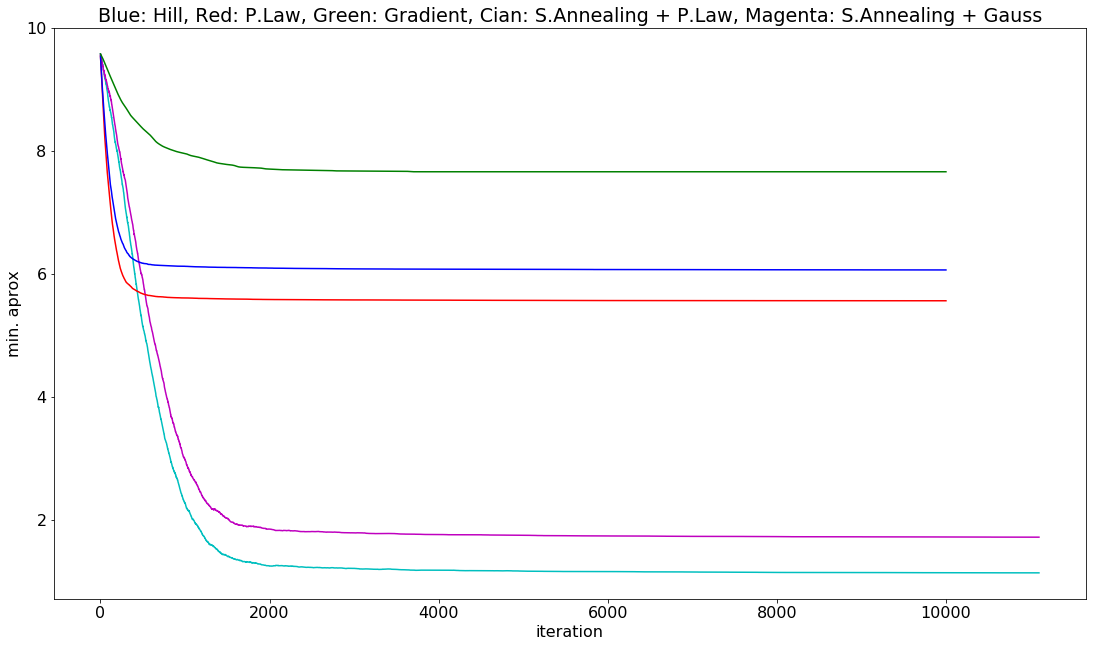

In [35]:
# plot the cost
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations_PwrSimanneal),
         np.squeeze(OUT_List_PwrSimanneal),
         'c-',
         np.squeeze(Iterations_GaussSimanneal),
         np.squeeze(OUT_List_GaussSimanneal),
         'm-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_PowerLaw),
         'r-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_HillRice),
         'b-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_Gradient),
         'g-',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("Blue: Hill, Red: P.Law, Green: Gradient, Cian: S.Annealing + P.Law, Magenta: S.Annealing + Gauss")
plt.savefig('griewankMinCureveII.pdf', format='pdf')
plt.show()


Best PowerLaw mean 5.563746: 
Best PowerLaw std 2.581358: 


<function matplotlib.pyplot.show(*args, **kw)>

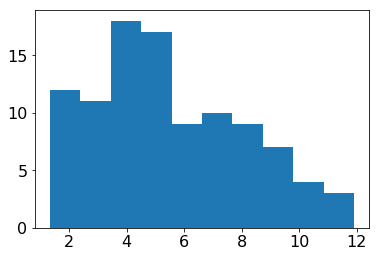

In [36]:
print("Best PowerLaw mean %f: " % np.mean(Best_List_PowerLaw))
print("Best PowerLaw std %f: " % np.std(Best_List_PowerLaw))
plt.hist(Best_List_PowerLaw)
plt.show

Best HillRice mean 6.064438: 
Best HillRice std 2.335140: 


<function matplotlib.pyplot.show(*args, **kw)>

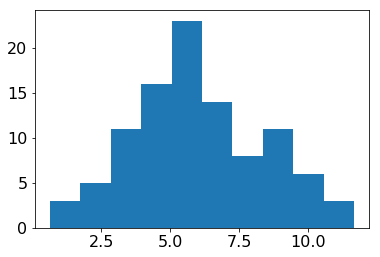

In [37]:
print("Best HillRice mean %f: " % np.mean(Best_List_HillRice))
print("Best HillRice std %f: " % np.std(Best_List_HillRice))
plt.hist(Best_List_HillRice)
plt.show

Best Gradient mean 7.659119: 
Best Gradient std 2.354471: 


<function matplotlib.pyplot.show(*args, **kw)>

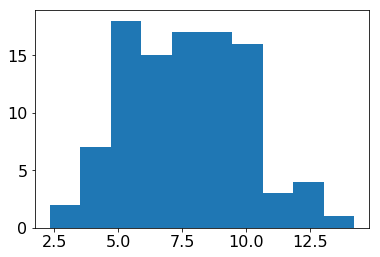

In [38]:
print("Best Gradient mean %f: " % np.mean(Best_List_Gradient))
print("Best Gradient std %f: " % np.std(Best_List_Gradient))
plt.hist(Best_List_Gradient)
plt.show

Best Best_List_PwrSimanneal mean 1.139227: 
Best Best_List_PwrSimanneal std 0.806549: 


<function matplotlib.pyplot.show(*args, **kw)>

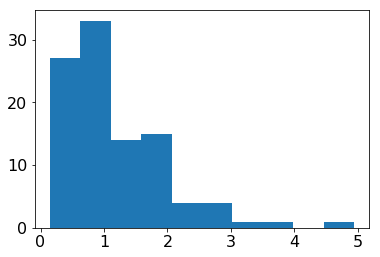

In [39]:
print("Best Best_List_PwrSimanneal mean %f: " % np.mean(Best_List_PwrSimanneal))
print("Best Best_List_PwrSimanneal std %f: " % np.std(Best_List_PwrSimanneal))
plt.hist(Best_List_PwrSimanneal)
plt.show

Best Best_List_GaussSimanneal mean 1.721680: 
Best Best_List_GaussSimanneal std 0.995707: 


<function matplotlib.pyplot.show(*args, **kw)>

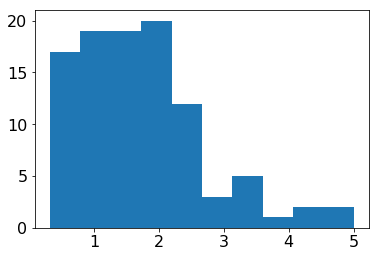

In [40]:
print("Best Best_List_GaussSimanneal mean %f: " % np.mean(Best_List_GaussSimanneal))
print("Best Best_List_GaussSimanneal std %f: " % np.std(Best_List_GaussSimanneal))
plt.hist(Best_List_GaussSimanneal)
plt.show

